In [97]:
import pandas as pd
import requests
import json
from pandas_datareader import data


In [198]:
ticker = 'NFLX'


In [199]:
si_data = requests.get(f'https://api.nasdaq.com/api/quote/{ticker}/short-interest?assetClass=stocks',
                    headers={"Accept-Language": "en-US,en;q=0.9",
                             "Accept-Encoding": "gzip, deflate, br",
                             "User-Agent": "Java-http-client/"}).text


In [200]:
price_data = data.DataReader(ticker, 'yahoo', '2020-10-01', '2021-10-03')
price_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-30,504.630005,489.269989,492.570007,500.029999,4634100,500.029999
2020-10-01,529.549988,503.600006,506.029999,527.510010,8153700,527.510010
2020-10-02,526.369995,502.700012,516.429993,503.059998,6071200,503.059998
2020-10-05,520.989990,501.700012,506.799988,520.650024,4088100,520.650024
2020-10-06,521.820007,504.160004,518.719971,505.869995,4199000,505.869995
...,...,...,...,...,...,...
2021-09-27,593.580017,576.929993,587.950012,592.640015,2504700,592.640015
2021-09-28,599.539978,580.159973,589.000000,583.849976,4431100,583.849976
2021-09-29,609.880005,588.010010,589.010010,599.059998,6221000,599.059998


In [201]:
data_json = json.loads(si_data)
si_df = pd.json_normalize(data_json, record_path=['data','shortInterestTable', 'rows'])
si_df['date'] = pd.to_datetime(si_df['settlementDate'])
si_df

,settlementDate,interest,avgDailyShareVolume,daysToCover,date
0,09/15/2021,"10,290,955","4,170,243",2.467711,2021-09-15
1,08/31/2021,"10,187,662","2,898,002",3.515409,2021-08-31
2,08/13/2021,"9,411,019","1,998,189",4.709774,2021-08-13
3,07/30/2021,"10,020,669","4,159,580",2.409058,2021-07-30
4,07/15/2021,"9,731,049","3,109,174",3.129786,2021-07-15
5,06/30/2021,"9,635,140","3,937,496",2.447022,2021-06-30
6,06/15/2021,"8,930,701","3,170,872",2.816481,2021-06-15
7,05/28/2021,"9,093,589","2,620,709",3.469897,2021-05-28
8,05/14/2021,"9,122,498","3,468,573",2.630044,2021-05-14
9,04/30/2021,"9,796,027","6,749,888",1.451287,2021-04-30


In [202]:
ibd_content = requests.get(f'https://iborrowdesk.com/api/ticker/{ticker}').text


In [203]:
ibd_json = json.loads(ibd_content)
ibd_df = pd.json_normalize(ibd_json, record_path=['daily'])
ibd_df['date'] = pd.to_datetime(ibd_df['time'])
ibd_df

,available,fee,time,date
0,10000000,0.2500,2020-10-06,2020-10-06
1,10000000,0.2500,2020-10-07,2020-10-07
2,10000000,0.2500,2020-10-08,2020-10-08
3,10000000,0.2500,2020-10-09,2020-10-09
4,10000000,0.2500,2020-10-12,2020-10-12
...,...,...,...,...
256,10000000,0.2500,2021-09-29,2021-09-29
257,10000000,0.2500,2021-09-30,2021-09-30
258,10000000,0.2500,2021-10-01,2021-10-01
259,10000000,0.3116,2021-10-04,2021-10-04


<AxesSubplot:xlabel='date'>

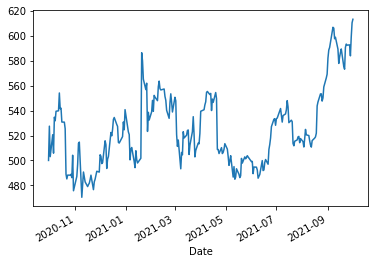

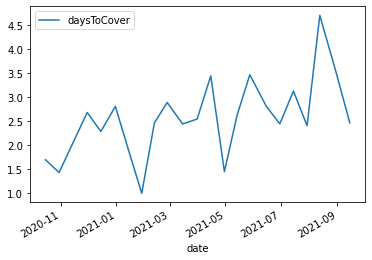

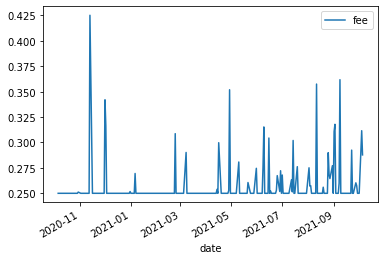

In [204]:
price_data['Adj Close'].plot()
si_df.plot(x='date')
ibd_df.plot(x='date', y='fee')

In [205]:
avg_borrowing_fee = ibd_df['fee'].mean()
print(f"Average borrowing fee: {avg_borrowing_fee}")
avg_si_ratio = si_df['daysToCover'].mean()
print(f"Average short interest ratio: {avg_si_ratio}")


Average borrowing fee: 0.25656398467432956
Average short interest ratio: 2.5489832173913043


In [206]:
ret_series = (1 + price_data['Adj Close'].pct_change()).cumprod() - 1
annual_return_row = ret_series.tail(1)
annual_return = annual_return_row[0]

In [207]:
# only uncomment when creating new data
# store = pd.DataFrame(None,columns=['Average borrowing fee', 'Average short interest ratio', 'Annual return'])

In [208]:
store.loc[ticker] = pd.Series([avg_borrowing_fee, avg_si_ratio, annual_return], index=store.columns)

store

,Average borrowing fee,Average short interest ratio,Annual return
AAPL,0.250622,1.176066,0.239681
MSFT,0.251285,1.848901,0.387119
GOOG,0.252664,2.089006,0.857138
AMZN,0.250222,1.323633,0.042725
FB,0.250389,1.681672,0.309698
TSLA,0.254098,1.518566,0.806997
NVDA,0.251636,1.052046,0.534586
NFLX,0.256564,2.548983,0.226226


In [209]:
store.to_csv('store.csv')